# ACIT4610 Problem Statement 2
This assignment focuses on optimizing a financial portfolio with the single objective of
maximizing expected return. You will implement and compare different versions of
Evolutionary Programming (EP) and Evolutionary Strategies (ES), including the (μ + λ) and
(μ, λ) strategies, to determine which approach yields the best portfolio allocation.

In [82]:
""" Setup the environment for the notebook """
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

""" Importlib is used to reload the module after changes.
    This is useful when developing the module and testing it in the notebook.
    The reload is done by running the cell again.

    REMEMBER TO ADD THE MODULE BELOW FOR RELOADING.
"""
import importlib

from utils.finance import finance_manager as finance
importlib.reload(finance) # Sync changes in the module


<module 'utils.finance.finance_manager' from '/home/jensen/ACIT/ACIT4610/Exam/ACIT4610_Portifolio_KMHS/problem_2/utils/finance/finance_manager.py'>

## Data Preprocessing Section

1. Download the data
2. Calculate Monthly Returns
3. Covariance Matrix

In [83]:
""" Data Requirements:
Data Source:    Yahoo Finance
Data Type:      Historical Daily Stock Prices
Data Period:    01/01/2018 - 12/31/2022
Data Columns:   Date, Open, High, Low, Close, Volume (Can be more).
Description:    Need to have 20 different stocks to analyze and
    compute monthly returns.
"""

DATA_PERIOD = {
    'start': datetime.datetime(2018, 1, 1),
    'end': datetime.datetime(2022, 12, 31),
    'interval': '1d',
}

STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NOD.OL']

manager = finance.TickerManager(STOCK_TICKERS, **DATA_PERIOD)
df = manager.get_stock_history()
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2018-01-02 00:00:00-05:00,40.074352,40.578343,39.862391,40.568920,102223600,0.0,0.0,AAPL
2018-01-03 00:00:00-05:00,40.632513,41.108244,40.498274,40.561859,118071600,0.0,0.0,AAPL
2018-01-04 00:00:00-05:00,40.634862,40.853888,40.526530,40.750263,89738400,0.0,0.0,AAPL
2018-01-05 00:00:00-05:00,40.846827,41.301359,40.754978,41.214222,94640000,0.0,0.0,AAPL
2018-01-08 00:00:00-05:00,41.061142,41.357883,40.962225,41.061142,82271200,0.0,0.0,AAPL


In [84]:
manager['NOD.OL'].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2018-01-02 00:00:00+01:00,3.980524,4.113208,3.952092,4.075298,348643,0.0,0.0,NOD.OL
2018-01-03 00:00:00+01:00,4.075298,4.122685,4.037388,4.122685,334311,0.0,0.0,NOD.OL
2018-01-04 00:00:00+01:00,4.141640,4.321711,4.132163,4.321711,567401,0.0,0.0,NOD.OL
2018-01-05 00:00:00+01:00,4.321711,4.383315,4.189028,4.369099,378158,0.0,0.0,NOD.OL
2018-01-08 00:00:00+01:00,4.369099,4.397531,4.226937,4.326450,289170,0.0,0.0,NOD.OL


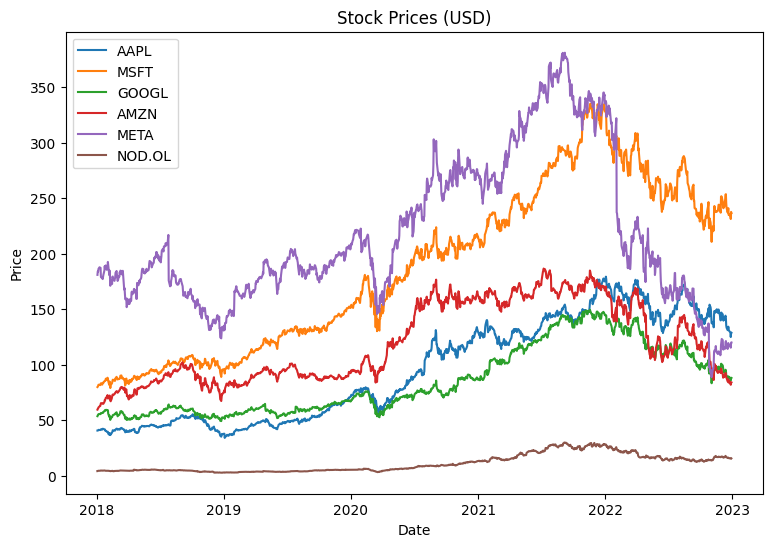

In [85]:
plt.figure(figsize=(9, 6))
for ticker in STOCK_TICKERS:
    plt.plot(manager[ticker]['Close'], label=ticker)
plt.title('Stock Prices (USD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Get monthly returns from the tickers

In [86]:
monthly_returns_list = []

for ticker in STOCK_TICKERS:
        company = manager.get(ticker)
        monthly_returns_df = company.get_monthly_returns()
        if not monthly_returns_df.empty:
            monthly_returns_list.append(monthly_returns_df)

all_monthly_returns_df = pd.concat(monthly_returns_list, ignore_index=True)

all_monthly_returns_df.head()


,Date,Ticker,Open,Close,Monthly Returns(%)
0,"(2018, 2)",AAPL,39.370190,42.120045,0.068185
1,"(2018, 3)",AAPL,42.219358,39.674950,-0.058051
2,"(2018, 4)",AAPL,39.405376,39.079044,-0.015020
3,"(2018, 5)",AAPL,39.350986,44.359566,0.135124
4,"(2018, 6)",AAPL,44.625433,43.941765,-0.009419
